# Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Mitigate Bias using Exponentiated Gradient with Demographic Parity constraint
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
import warnings
warnings.filterwarnings('ignore')

# Part 1: Load the dataset + Preprocessing

In [2]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]
data = pd.read_csv(url, names=columns)

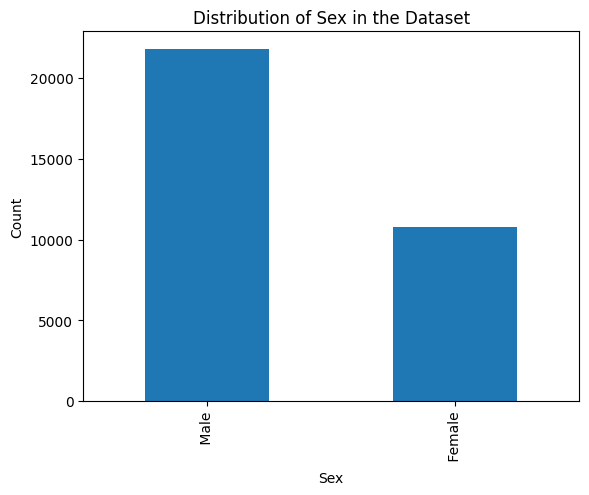

In [3]:
#graphical representation of the sex column in the dataset
import matplotlib.pyplot as plt

# Plot the distribution of the 'sex' column
data['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of Sex in the Dataset')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

As we can see there is a disparity between male and female in our dataset

In [4]:
# Basic preprocessing
data = data.replace(' ?', pd.NA).dropna()

# Convert categorical columns to dummy variables
data = pd.get_dummies(data, drop_first=True)


In [5]:
# Split into features (X) and labels (y)
X = data.drop('income_ >50K', axis=1)  # Target column (1 if >50K, 0 if <=50K)
y = data['income_ >50K']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Part 2 : Train model

In [6]:

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f'Original Accuracy: {accuracy_original:.4f}')

Original Accuracy: 0.8458


# Part 3: Implement Guardrails for Fairness

**Check for Bias**: We will now check if the model is biased toward specific groups (e.g., based on gender or race). We’ll use the Fairlearn library to evaluate fairness.

In [7]:
# Evaluate fairness on gender (0 = Female, 1 = Male)
from fairlearn.metrics import demographic_parity_difference

sex_feature = X_test['sex_ Male']  # 'sex_ Male' is the column indicating gender
fairness_score_original = demographic_parity_difference(
    y_test, y_pred, sensitive_features=sex_feature
)
print(f'Original Fairness Score (Demographic Parity Difference for Gender): {fairness_score_original:.4f}')

Original Fairness Score (Demographic Parity Difference for Gender): 0.1903


there is a demographic disparity in the models predictions. there is 19% difference in positive outcome (like loan approval) between two groups. The closer de fairness score is to 0, then better. In our case we check why it has such bias.

Mitigate Bias If the model shows bias, we use Fairlearn’s mitigation strategies like reweighting or post-processing to reduce it.

In [8]:
# Ensure compatibility with Fairlearn
import numpy as np
np.seterr(all='ignore')

mitigator = ExponentiatedGradient(
    LogisticRegression(solver='liblinear'), constraints=DemographicParity()
)
mitigator.fit(X_train, y_train, sensitive_features=X_train['sex_ Male'])
y_pred_mitigated = mitigator.predict(X_test)

# Evaluate the mitigated model
accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
print(f'Accuracy after Mitigation: {accuracy_mitigated:.4f}')

Accuracy after Mitigation: 0.7825


# Part 4: Re-evaluate fairness on gender

In [9]:
# Re-evaluate fairness on gender
fairness_score_mitigated = demographic_parity_difference(
    y_test, y_pred_mitigated, sensitive_features=sex_feature
)
print(f'Fairness Score after Mitigation (Demographic Parity Difference for Gender): {fairness_score_mitigated:.4f}')

# Compare the results
print("\nComparison:")
print(f"Accuracy Improvement: {accuracy_mitigated - accuracy_original:.4f}")
print(f"Fairness Improvement: {fairness_score_original - fairness_score_mitigated:.4f}")


Fairness Score after Mitigation (Demographic Parity Difference for Gender): 0.0076

Comparison:
Accuracy Improvement: -0.0633
Fairness Improvement: 0.1827


# Conclusion

As we can see, we decreased the Accuracy score from 84% to 79% but in return we improved the Fairness regarding gender by 18.73%. Which was the goal, to improve the fairness of our model.
To accomplish that we build a linear Regression model, and after that we used the demographic parity difference metric, which tells us if each group (in our case the genders) have the same selection rate. During the first training, we received a demographic parity differnece of 19%. This means that the 2 groups (male, female) were not equal in their selection rate. As such our goal was to reduce that number. 
One way was probably to reduce the number of male or female that our dataset had. To create fairness in our dataset we used the mitigation strategies that our library offered using the Exponentiated GFradient. and we made a new model. 
The accuracy was reduced but the fairness was better.
We will do further research on that.
